In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1070 with Max-Q Design


In [3]:
# Load the dataset
file_path = 'Training_Essay_Data.csv'
dataset = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(dataset.head())
# Check the dataset information
print(dataset['generated'].value_counts())
dataset.info()

                                                text  generated
0  Car-free cities have become a subject of incre...          1
1  Car Free Cities  Car-free cities, a concept ga...          1
2    A Sustainable Urban Future  Car-free cities ...          1
3    Pioneering Sustainable Urban Living  In an e...          1
4    The Path to Sustainable Urban Living  In an ...          1
generated
0    17508
1    11637
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29145 entries, 0 to 29144
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       29145 non-null  object
 1   generated  29145 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 455.5+ KB


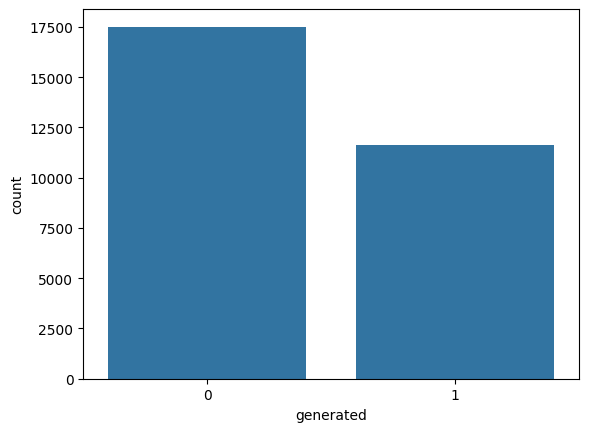

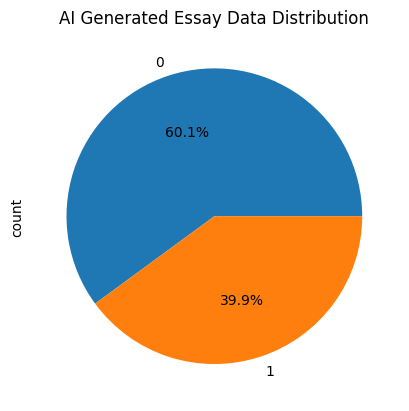

In [4]:
sns.countplot(x=dataset['generated'])
plt.show()

dataset['generated'].value_counts().plot(kind="pie",autopct="%.1f%%")
plt.title("AI Generated Essay Data Distribution")
plt.show()

In [5]:
# Balancing the dataset by oversampling the minority class
def balance_labels(df, label_column='generated'):
    # Get the counts of each label
    label_counts=df[label_column].value_counts()
    # Get the maximum count
    max_count=label_counts.max()
    # Create an empty DataFrame
    balanced_df=pd.DataFrame()

    # For each label, create a subset of the DataFrame with that label
    for label, count in label_counts.items():
        # If the count is equal to the maximum count, don't do anything
        label_subset = df[df[label_column]==label]
        # Create a subset of the label with replacement
        oversampled_subset= label_subset.sample(n=(max_count-count), replace=True, random_state=42)
        balanced_df = pd.concat([balanced_df, label_subset, oversampled_subset], ignore_index=True)

    return balanced_df

dataset = balance_labels(dataset)

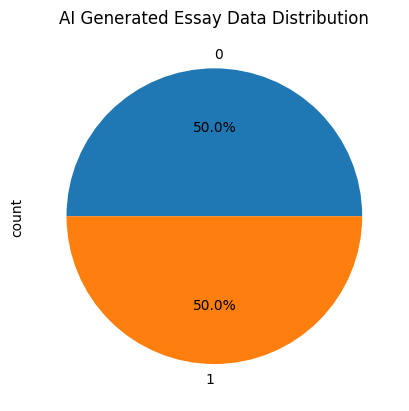

generated
0    17508
1    17508
Name: count, dtype: int64

In [6]:
dataset['generated'].value_counts().plot(kind="pie",autopct="%.1f%%")
plt.title("AI Generated Essay Data Distribution")
plt.show()
# Check the dataset statistics
dataset['generated'].value_counts()

In [28]:
# Check for missing values
print(dataset.isnull().sum())

# Drop rows with missing values (if any)
dataset.dropna(inplace=True)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset['text'], dataset['generated'], test_size=0.2, random_state=42)


text         0
generated    0
dtype: int64


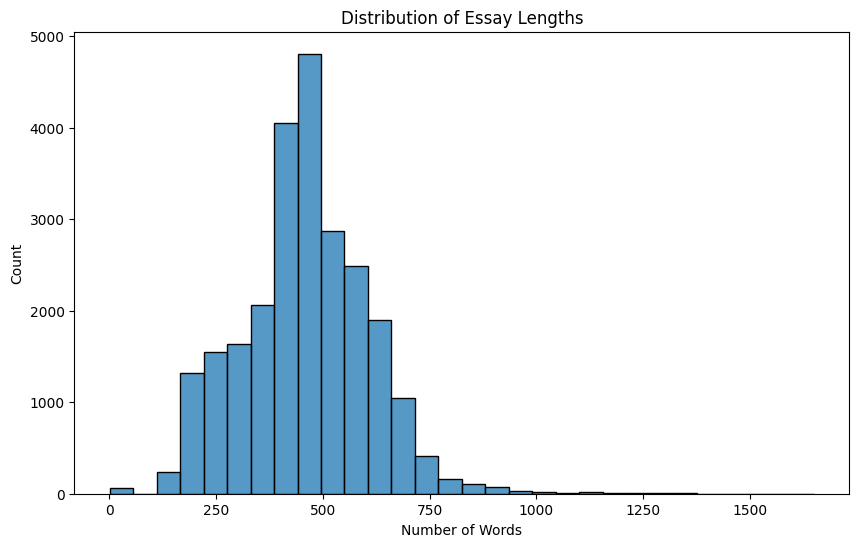

Ave Length:  458 words
Min Length:  1 words
Max Length:  1650 words


In [29]:
# Ploy the distribution of the essay lengths
plt.figure(figsize=(10, 6))
sns.histplot(dataset['text'].apply(lambda x: len(x.split())), bins=30)
plt.title('Distribution of Essay Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

# Get average length of the essays
avg_length = dataset['text'].apply(lambda x: len(x.split())).mean()
# Get the min and max length of the essays
min_length = dataset['text'].apply(lambda x: len(x.split())).min()
max_length = dataset['text'].apply(lambda x: len(x.split())).max()
print("Ave Length: ", round(avg_length), "words")
print("Min Length: ", min_length, "words")
print("Max Length: ", max_length, "words")

### TF-IDF with ngram_range setting and regularization & penalty intensity tuning

In [55]:
from sklearn.metrics import f1_score

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=0.01)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#use L2 regularizaiton with sage solver(since better for reducing overfitting and also better for preventing sparsity matrix)
#and since the dataset is already oversampled, we do not need to apply class_weight="balanced") in logisticRegression
lr_model = LogisticRegression(
    penalty='l2', random_state=50, solver="saga"
)
lr_model.fit(X_train_tfidf, y_train)

y_pred = lr_model.predict(X_test_tfidf)
f1_micro = f1_score(y_test, y_pred, average="micro")
###f1_macro = f1_score(y_test, y_pred, average="macro")

#print out f1 results
print('f1 score for micro-averaging is:', f1_micro)
###print('f1 score for macro-averaging is:', f1_macro)

f1 score for micro-averaging is: 0.9985929648241206


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [56]:
###pip install optuna
import optuna

#fine tune the reverse of regulartization(intensity) with optuna optimization
dist = {
    "C": optuna.distributions.FloatDistribution(1e-8, 100.0, log=True),
}

#we have to maximize the C value for the optimal penality intensity
study = optuna.create_study(direction="maximize")
trials = 15

for _ in range(trials):
    trial = study.ask(dist)
    C = trial.params["C"]
    clf = LogisticRegression(C=C, solver="saga", max_iter=1000)
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)
    f1 = f1_score(y_test, y_pred, average="micro")

    study.tell(trial, f1)

study.best_params, study.best_value

[I 2024-07-30 16:38:27,441] A new study created in memory with name: no-name-cec4060b-b595-40b1-9dca-9d88856fb0f7


({'C': 15.560335117665725}, 1.0)

In [59]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=0.01)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#use L2 regularizaiton with sage solver(since better for reducing overfitting and also better for preventing sparsity matrix)
#and since the dataset is already oversampled, we do not need to apply class_weight="balanced") in logisticRegression
lr_model = LogisticRegression(
    C=15.560335117665725, penalty='l2', random_state=50, solver="saga"
)
lr_model.fit(X_train_tfidf, y_train)

y_pred = lr_model.predict(X_test_tfidf)
f1_micro = f1_score(y_test, y_pred, average="micro")

#print out f1 results
print('f1 score for micro-averaging is:', f1_micro)
#print out accuracy and report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

f1 score for micro-averaging is: 1.0
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2515
         1.0       1.00      1.00      1.00      2460

    accuracy                           1.00      4975
   macro avg       1.00      1.00      1.00      4975
weighted avg       1.00      1.00      1.00      4975



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### TF-IDF without regularization & penalty intensity tuning

In [57]:
# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=0.01)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train a logistic regression model
lr_model = LogisticRegression(random_state=50)
lr_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1_micro = f1_score(y_test, y_pred, average="micro")
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('f1 score is:', f1_micro)
print(f'Classification Report:\n{report}')

Accuracy: 0.9981909547738693
f1 score is: 0.9981909547738693
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2515
         1.0       1.00      1.00      1.00      2460

    accuracy                           1.00      4975
   macro avg       1.00      1.00      1.00      4975
weighted avg       1.00      1.00      1.00      4975

